<a href="https://colab.research.google.com/github/namhwui/MixtureAlgos_py/blob/main/Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

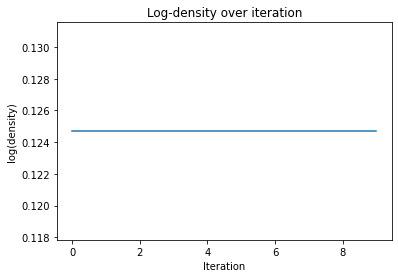

array([3.66704271e-118, 9.16760677e-121, 1.83352135e-119, 1.83352135e-119])

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import multivariate_normal


def mixture_density(x, model, logged = False, post = False):
  # computes density of G-component Gaussian mixture model
  # if logged = True, log-density is returned
  # if logged = False, and post = True, then a length-G array of component-wise
  #   posterior membership probabilities is returned
  G = model['G']
  param = model['param']
  val = np.zeros(G) # Allocating an array of appropriate length a priori is better than iterative appending, like in R

  for g in range(0, G):
    val[g] = model['prop'][g] * multivariate_normal.pdf(x, mean=param[g]['mu'], cov=param[g]['sigma'])

  if logged:
    return(np.log(np.sum(val))) # np.sum is faster on numpy arrays, but sum is faster on lists
  elif post:
    return(val / np.sum(val))
  else:
    return(np.sum(val))
  
def meanshift_Gauss_update(x, model):
  # computes a single-iteration update for Gaussian mean-shift
  G = model['G']
  param = model['param']
  p = len(x)
  A = np.zeros([p, p])
  b = np.zeros(p)
  posterior = mixture_density(x, model, post = True)

  for g in range(0, G):
    A += posterior[g] * param[g]['invsigma']
    b += posterior[g] * param[g]['invsigma'] @ param[g]['mu']  # @ is a matrix vector multiplication sign, like %*% in R
  
  return(inv(A) @ b)


def meanshift_Gauss(x, model, iter = 10):
  # iterates Gaussian mean-shift 'iter' many times
  # returns a dictionary:
  #      x: mean-shift solution
  #   logl: sequence of mixture model log-density computed at each iteration
  # TO-DO: implement convergence criterion
  logl = np.zeros(iter)
  newx = x
  for g in range(0, model['G']):
    model['param'][g]['invsigma'] = inv(model['param'][g]['sigma'])

  for ii in range(iter):
    newx = meanshift_Gauss_update(newx, model)
    logl[ii] = mixture_density(newx, model, logged = True)

  return({'x':newx, 'logl':logl})



# toy example
# 2-component Gaussian
param = [{'mu': np.array([0,0,0,0]), 
          'sigma': np.array([[1,0,0,0], [0,0.05,0,0], [0,0,0.05,0], [0,0,0,0.05]])}, 
         {'mu': np.array([3,3,3,3]),
          'sigma':np.array([[0.05,0,0,0], [0,1,0,0], [0,0,0.05,0], [0,0,0,0.05]])}]

model = {'prop':np.array([0.5, 0.5])}
model['param'] = param
model['G'] = len(model['prop'])

x = np.array([1, 1, 1, 1])
result = meanshift_Gauss(x, model, iter = 10)
#plt.plot(result['logl'])
#plt.title('Log-density over iteration')
#plt.xlabel('Iteration')
#plt.ylabel('log(density)')
#plt.show()
result['x']
